In [9]:
!pip install patchify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
!pip install rasterio

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import os
from torch.utils.data import Dataset, DataLoader, random_split
import random
import torch
from torchvision import transforms
from PIL import Image


In [10]:
large_image_stack = tiff.imread("/kaggle/input/datasettt/data-20240831T101900Z-001/data/images/0.tif")
large_image_stack.shape

(128, 128, 12)

The shape `(128, 128, 12)` represents the dimensions of the `large_image_stack` array. Here's what each number means:

- **128**: The height of the image.
- **128**: The width of the image.
- **12**: The number of slices or layers in the image stack.

So, this array is a 3D image stack with 12 layers, each of size 128x128 pixels. This is common in medical imaging or other fields where images are captured in slices. 

An image stack with 12 layers means that you have a series of 12 images that are stacked together, one on top of the other. Each layer is a 2D image of size 128x128 pixels.

This is often used in medical imaging, like MRI or CT scans, where multiple slices of an object (like a human body) are captured at different depths. When you stack these slices together, you get a 3D representation of the object.

Think of it like a flipbook, where each page is a layer of the image stack. When you flip through the pages, you can see the object in three dimensions.

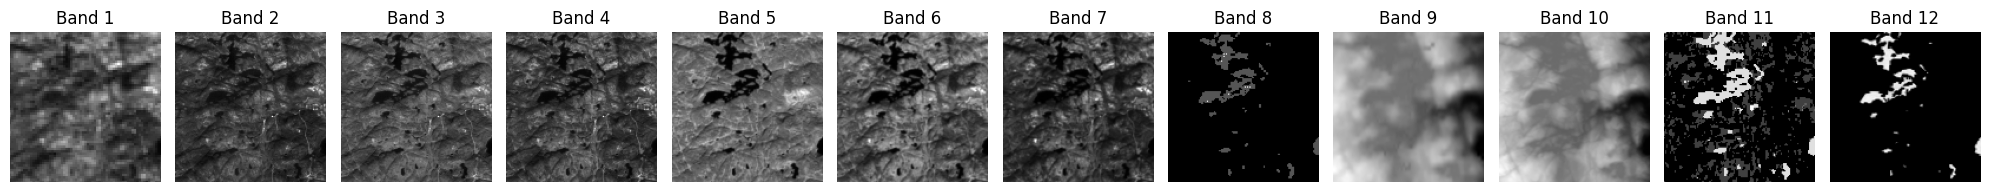

In [11]:
num_bands = large_image_stack.shape[2]

fig, axes = plt.subplots(1, num_bands, figsize=(20, 10))
for i in range(num_bands):
    axes[i].imshow(large_image_stack[:, :, i], cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Devide Dataset

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import tifffile as tiff
from sklearn.model_selection import train_test_split

image_dir = '/kaggle/input/datasettt/data-20240831T101900Z-001/data/images'
label_dir = '/kaggle/input/datasettt/data-20240831T101900Z-001/data/labels'

# Function to load images and labels
def load_data(image_dir, label_dir):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.tif'):
            # Load image using tifffile
            image_path = os.path.join(image_dir, filename)
            image = tiff.imread(image_path)

            # Load corresponding label
            label_path = os.path.join(label_dir, filename.replace('.tif', '.png'))
            if os.path.exists(label_path):
                label = Image.open(label_path)
                label = np.array(label)
                images.append(image)
                labels.append(label)
                filenames.append((filename, filename.replace('.tif', '.png')))
            else:
                print(f"Label for {filename} not found.")

    return np.array(images), np.array(labels), filenames




In [ ]:
images, labels, filenames = load_data(image_dir, label_dir)

X_train, X_temp, y_train, y_temp, train_filenames, temp_filenames = train_test_split(images, labels, filenames, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, val_filenames, test_filenames = train_test_split(X_temp, y_temp, temp_filenames, test_size=0.5, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch and prefetch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [23]:
if train_filenames:
    print(f"First image in training set: {train_filenames[0][0]}, First label in training set: {train_filenames[0][1]}")
else:
    print("No images found in training set.")

# Print dataset shapes
print(f'Train dataset: {train_dataset}')
print(f'Validation dataset: {val_dataset}')
print(f'Test dataset: {test_dataset}')

First image in training set: 255.tif, First label in training set: 255.png
Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 12), dtype=tf.int16, name=None), TensorSpec(shape=(None, 128, 128), dtype=tf.uint8, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 12), dtype=tf.int16, name=None), TensorSpec(shape=(None, 128, 128), dtype=tf.uint8, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 12), dtype=tf.int16, name=None), TensorSpec(shape=(None, 128, 128), dtype=tf.uint8, name=None))>


In [24]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import he_normal

def unet_model(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)

    # Modify the first convolutional layer to accept 12 channels
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer=he_normal(), name='custom_conv1_conv')(inputs)
    x = layers.BatchNormalization(axis=-1, name='custom_conv1_bn')(x)
    x = layers.Activation('relu', name='custom_conv1_relu')(x)
    
    # Load pre-trained ResNet50 without the first layer
    resnet50 = ResNet50(include_top=False, weights=None, input_tensor=x)
    
    # Extract feature maps from ResNet50
    c1 = resnet50.get_layer('conv1_relu').output  # 64x64x64
    c2 = resnet50.get_layer('conv2_block3_out').output  # 32x32x256
    c3 = resnet50.get_layer('conv3_block4_out').output  # 16x16x512
    c4 = resnet50.get_layer('conv4_block6_out').output  # 8x8x1024
    c5 = resnet50.get_layer('conv5_block3_out').output  # 4x4x2048

    # Decoder
    u6 = layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    u10 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u10)
    c10 = layers.BatchNormalization()(c10)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c10)
    c10 = layers.BatchNormalization()(c10)

    # Ensure the output has the same spatial dimensions as the input
    u11 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
    c11 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u11)
    c11 = layers.BatchNormalization()(c11)
    c11 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c11)
    c11 = layers.BatchNormalization()(c11)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [25]:
import numpy as np
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Call the parent class constructor
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[indices]
        y_batch = self.y[indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def get_labels(self):
        return self.y

# Create an instance of the custom data generator
train_generator = CustomDataGenerator(X_train, y_train, batch_size=32)
val_generator = CustomDataGenerator(X_val, y_val, batch_size=32, shuffle=False)





In [27]:
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set a smaller initial learning rate
initial_learning_rate = 1e-4

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Create an instance of the custom data generator
train_generator = CustomDataGenerator(X_train, y_train, batch_size=32)
val_generator = CustomDataGenerator(X_val, y_val, batch_size=32, shuffle=False)

# Compile the model with the smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    callbacks=[lr_scheduler])


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5272 - loss: 0.8561 - val_accuracy: 0.4237 - val_loss: 0.6980 - learning_rate: 1.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.6505 - loss: 0.6386 - val_accuracy: 0.5010 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.7564 - loss: 0.5202 - val_accuracy: 0.6440 - val_loss: 0.6847 - learning_rate: 1.0000e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8033 - loss: 0.4797 - val_accuracy: 0.7886 - val_loss: 0.6700 - learning_rate: 1.0000e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8504 - loss: 0.4100 - val_accuracy: 0.8465 - val_loss: 0.6514 - learning_rate: 1.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8358 - loss: 0.4330 - val_accuracy: 0.8700 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.8782 - loss: 0

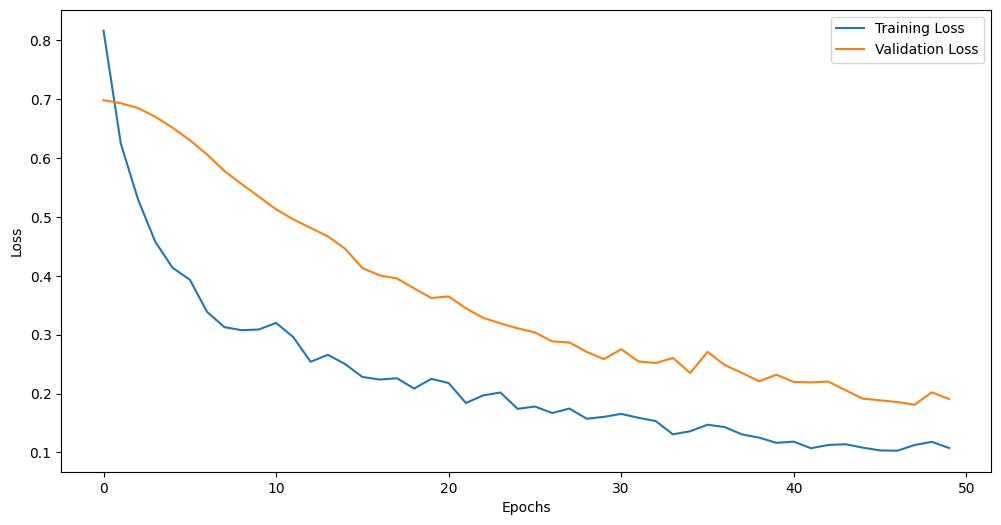

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



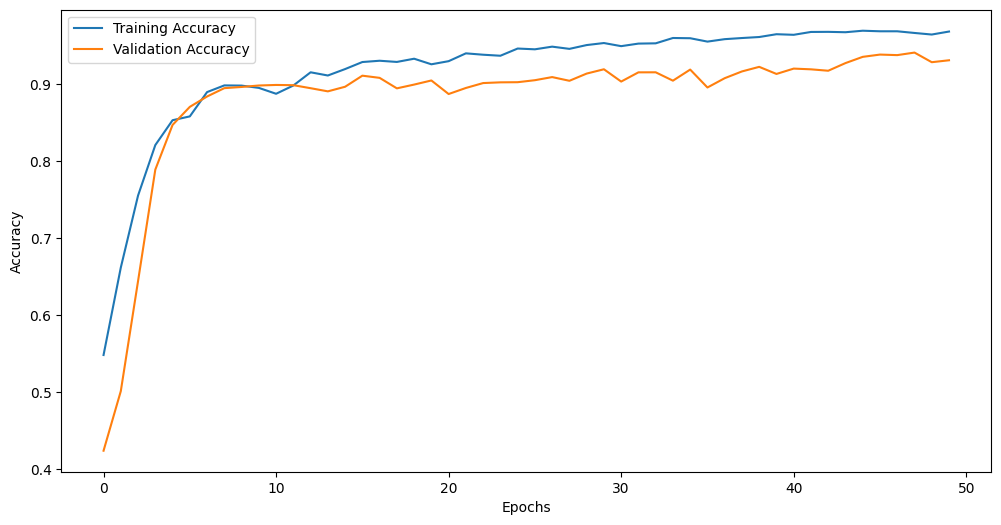

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [32]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8817 - loss: 0.3204  


[0.3242095112800598, 0.880422830581665]

In [33]:
import numpy as np
from sklearn.metrics import f1_score


y_true_flat = y_test.flatten()
y_pred_flat = np.argmax(y_pred, axis=-1).flatten()

# Check the shapes

# Calculate the F1 score
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
print(f"F1 Score: {f1}")


F1 Score: 0.5935328209582197


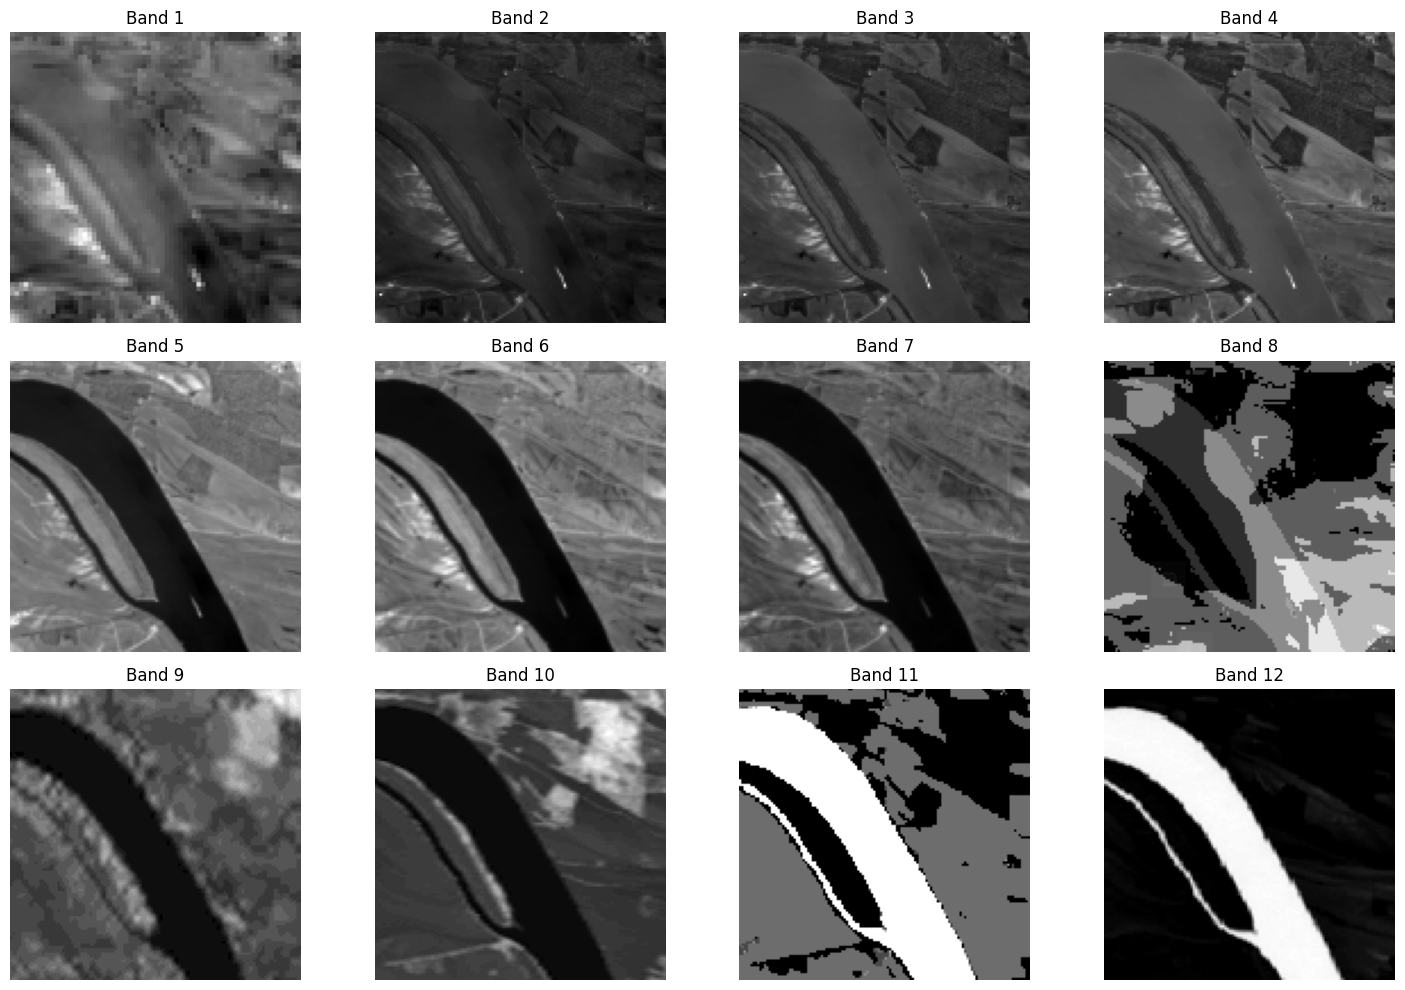

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


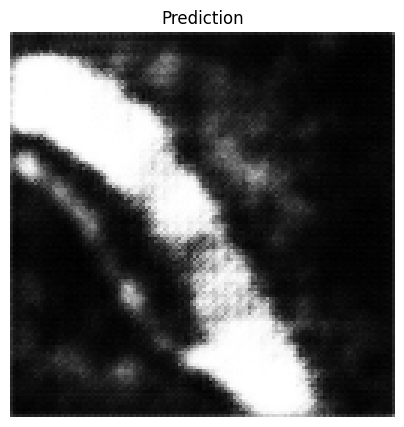

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Load the TIFF image
image_path = "/kaggle/input/datasettt/data-20240831T101900Z-001/data/images/277.tif"
image = tiff.imread(image_path)

# Ensure the image has the correct shape (128, 128, 12)
assert image.shape == (128, 128, 12), "Image shape must be (128, 128, 12)"

# Print the 12 bands of the image
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i in range(12):
    ax = axes[i // 4, i % 4]
    ax.imshow(image[:, :, i], cmap='gray')
    ax.set_title(f'Band {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Expand dimensions to match the model input
image_expanded = np.expand_dims(image, axis=0)

# Predict the segmentation mask
prediction = model.predict(image_expanded)

# Squeeze the prediction to remove the batch dimension
prediction_squeezed = np.squeeze(prediction)

# Print the prediction image
plt.figure(figsize=(5, 5))
plt.imshow(prediction_squeezed, cmap='gray')
plt.title('Prediction')
plt.axis('off')
plt.show()


In [22]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_true_flat, y_pred_flat, average='weighted')

recall = recall_score(y_true_flat, y_pred_flat, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5083587222199162
Recall: 0.7129927925441576
